In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyfits
import plotc
import read_params
import os
def fitsread(f): return np.squeeze(pyfits.getdata(f)).astype(float)
from matplotlib.ticker import MaxNLocator,ScalarFormatter
import fnmatch
from matplotlib import gridspec,rc
import itertools

#rc('text', usetex=False)
#rc('font',**{'family':'serif','serif':['Times']})

In [2]:
datadir = read_params.get_directory()
src = 4
src_loc = np.loadtxt(os.path.join(datadir,"master.pixels"))[src-1]
print "Source at",src_loc

Source at -2.0


In [3]:
nx = read_params.get_nx()
Lx = read_params.get_xlength()
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
dx = x[1]-x[0]
Rsun = 695.8
dt = read_params.get_dt()
Rsun=695.8
z=np.loadtxt(read_params.get_solarmodel(),usecols=[0])
z=(z-1)*Rsun
z_pixels = np.arange(len(z))
z_plot = np.interp(z_pixels[:-1]+0.5,z_pixels,z)
z_plot = np.append(z[0]-(z[1]-z[0])/2,np.append(z_plot,z[-1]+(z[-1]-z[-2])/2))

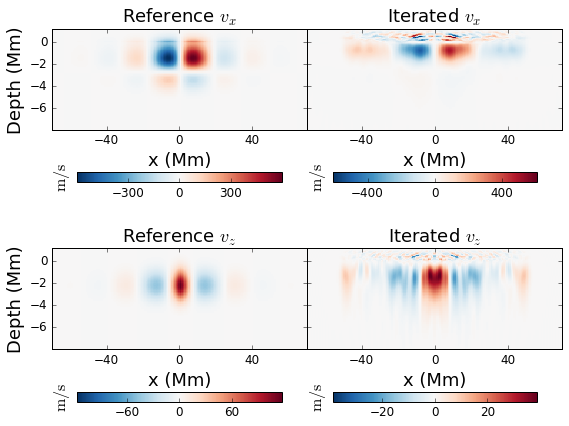

In [14]:
itercutoff = str(2).zfill(2)
true_vx = fitsread('true_vx.fits')
true_vz = fitsread('true_vz.fits')
current_vx = fitsread(os.path.join(datadir,'update','vx_'+itercutoff+'.fits'))
current_vz = fitsread(os.path.join(datadir,'update','vz_'+itercutoff+'.fits'))

yr_plot = [-5,None]
x_plot = np.append(x-dx/2,x[-1]+dx/2)

axlist = []
cblist = []
def add_subplot(sp_index,array,title=""):
    ax=plt.subplot(sp_index)
    array_max = abs(array).max()
    qm=ax.pcolorfast(x_plot,z_plot,array,vmax=array_max,vmin=-array_max,cmap="RdBu_r")
    cb=plt.colorbar(mappable=qm,orientation="horizontal",shrink=0.8,pad=0.25,ticks=MaxNLocator(5))
    plt.title(title,y=1.01,fontsize=18)
    axlist.append(ax)
    cblist.append(cb)

add_subplot(221,true_vx,title="Reference $v_x$")
add_subplot(222,current_vx,title="Iterated $v_x$")
add_subplot(223,true_vz,title="Reference $v_z$")
add_subplot(224,current_vz,title="Iterated $v_z$")

for ax in axlist:
    ax.set_xlim(-70,70)
    ax.set_ylim(-8,z.max())
    ax.set_xlabel("x (Mm)",fontsize=18)
    ax.xaxis.set_major_locator(MaxNLocator(4,prune="both"))
    ax.yaxis.set_major_locator(MaxNLocator(5,prune="both"))
    ax.tick_params(axis='both', labelsize=12)

axlist[0].set_ylabel("Depth (Mm)",fontsize=18)
plt.setp(axlist[1].get_yticklabels(),visible=False)
axlist[2].set_ylabel("Depth (Mm)",fontsize=18)
plt.setp(axlist[3].get_yticklabels(),visible=False)
    
for cb in cblist: 
    cb.ax.set_ylabel("$\mathrm{m}/\mathrm{s}$",rotation=90,fontsize=16)
    cb.ax.tick_params(axis="x",labelsize=12)
    
plt.gcf().set_size_inches(8,6)
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0.3)

if not os.path.exists('plots'): os.makedirs('plots')
plt.savefig('plots/iterated_vel.eps',bbox_inches='tight')

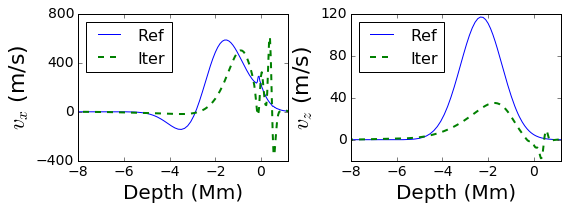

In [15]:
# rc('text', usetex=True)
# rc('font',**{'family':'serif','serif':['Times']})

ax1=plt.subplot(121)
def xind(x): return int((x/Lx+0.5)*nx)
plt.plot(z,true_vx[:,xind(8)],label="Ref")
plt.plot(z,current_vx[:,xind(8)],label="Iter",linewidth=2,ls="dashed")
plt.xlim(-8,z[-1]);
plt.legend(loc="best",fontsize=16);
plt.xlabel("Depth (Mm)",fontsize=20);
plt.ylabel("$v_x$ (m/s)",fontsize=22);
plt.tick_params(labelsize=14)

ax2=plt.subplot(122)
def xind(x): return int((x/Lx+0.5)*nx)
plt.plot(z,true_vz[:,xind(0)],label="Ref")
plt.plot(z,current_vz[:,xind(0)],label="Iter",linewidth=2,ls="dashed")
plt.xlim(-8,z[-1]);
plt.legend(loc="best",fontsize=16);
plt.xlabel("Depth (Mm)",fontsize=20);
plt.ylabel("$v_z$ (m/s)",fontsize=22);
plt.tick_params(labelsize=14)
plt.gcf().set_size_inches(8,3);
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)


for ax in [ax1,ax2]:
    ax.yaxis.set_major_locator(MaxNLocator(4))

    
if not os.path.exists('plots'): os.makedirs('plots')
plt.savefig('plots/iterated_vel_zcuts.eps',bbox_inches='tight')

## Model misfit

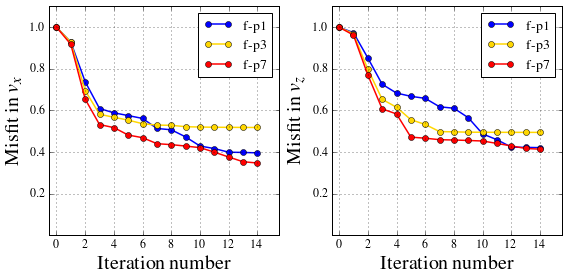

In [96]:
def integrate_2D(arr):
    return np.trapz(np.trapz(arr,x=x,axis=1),x=z)

f_p1_dir = read_params.get_directory()
f_p7_dir = os.path.join(os.path.dirname(f_p1_dir),"f_to_p7_512_4hr_hsmooth30_vsmooth8")
f_p3_dir = os.path.join(os.path.dirname(f_p1_dir),"f_to_p3_512_4hr_hsmooth30")
num_misfit_files=0

runs = {f_p1_dir:"f-p1",f_p7_dir:"f-p7",f_p3_dir:"f-p3"}

def plot_model_misfit(datadir,color="black",itercutoff=15):
    #~ Get a list of misfit files in the update directory
    misfitfiles=sorted([os.path.join(datadir,"update",f) for f in 
                        fnmatch.filter(os.listdir(os.path.join(datadir,"update")),'misfit_[0-9][0-9]')])

    num_misfit_files=len(misfitfiles)

    # vx
    truemodel=np.squeeze(pyfits.getdata("true_vx.fits"))

    modelmisfit_list = []

    model0=np.squeeze(pyfits.getdata(os.path.join(datadir,"update","vx_00.fits")))
    #~ model0_misfit=np.sum((truemodel-model0)**2)
    model0_misfit=integrate_2D((truemodel-model0)**2)

    for iterno in xrange(min(num_misfit_files,itercutoff)):
        itermodel=np.squeeze(pyfits.getdata(os.path.join(datadir,"update","vx_"+str(iterno).zfill(2)+".fits")))

        modelmisfit=integrate_2D((truemodel-itermodel)**2)


        modelmisfit/=model0_misfit

        modelmisfit_list.append(modelmisfit)

    plt.subplot(121)
    plt.plot(modelmisfit_list,linestyle='solid',linewidth=1.5,marker='o',label=runs.get(datadir),color=color)
    plt.grid(True)
    plt.legend(loc="best",fontsize=14)
    plt.xlabel("Iteration number",fontsize=20)
    plt.ylabel("Misfit in $v_x$",fontsize=20)
    plt.tick_params(labelsize=12)

    plt.gca().yaxis.set_major_locator(MaxNLocator(7,prune='both'))
    plt.xlim(-0.5,min(num_misfit_files,itercutoff)+0.5)
    plt.ylim(0,1.1)


    # vz
    truemodel=np.squeeze(pyfits.getdata("true_vz.fits"))

    modelmisfit_list = []
    model0=np.squeeze(pyfits.getdata(os.path.join(datadir,"update","vz_00.fits")))
    model0_misfit=integrate_2D((truemodel-model0)**2)

    for iterno in xrange(min(num_misfit_files,itercutoff)):    
        itermodel=np.squeeze(pyfits.getdata(os.path.join(datadir,"update","vz_"+str(iterno).zfill(2)+".fits")))

        modelmisfit=integrate_2D((truemodel-itermodel)**2)


        modelmisfit/=model0_misfit

        modelmisfit_list.append(modelmisfit)
    
    plt.subplot(122)
    plt.plot(modelmisfit_list,linestyle='solid',linewidth=1.5,marker='o',label=runs.get(datadir),color=color)
    plt.grid(True)
    plt.legend(loc="best",fontsize=14)
    plt.xlabel("Iteration number",fontsize=20)
    plt.ylabel("Misfit in $v_z$",fontsize=20)
    plt.tick_params(labelsize=12)

    plt.gca().yaxis.set_major_locator(MaxNLocator(7,prune='both'))
    plt.xlim(-0.5,min(num_misfit_files,itercutoff)+0.5)
    plt.ylim(0,1.1)

    # Vector potential
#     try:  
#         truemodel=np.squeeze(pyfits.getdata("true_psi.fits"))
#     except IOError:
#         print "True psi model doesn't exist"
#         quit()

#     modelmisfit_list = []

#     truemodel -= truemodel[0,0]

#     model0=np.squeeze(pyfits.getdata(os.path.join(datadir,"update","model_psi_00.fits")))
#     model0-=model0[0,0]
#     model0_misfit=integrate_2D((truemodel-model0)**2)

#     for iterno in xrange(min(num_misfit_files,itercutoff)):    
#         try:  
#             itermodel=np.squeeze(pyfits.getdata(os.path.join(datadir,"update",
#                                                 "model_psi_"+str(iterno).zfill(2)+".fits")))
#             itermodel -= itermodel[0,0]
#         except IOError:
#             print "model_psi_"+str(iterno).zfill(2)+".fits doesn't exist"
#             continue

#         modelmisfit=integrate_2D((truemodel-itermodel)**2)
#         modelmisfit/=model0_misfit
#         modelmisfit_list.append(modelmisfit)

#     plt.plot(modelmisfit_list,linestyle='dotted',marker='s',label=r"$\psi$",color=color)
    
    
plot_model_misfit(f_p1_dir,color="blue")
plot_model_misfit(f_p3_dir,color="gold")
plot_model_misfit(f_p7_dir,color="red")

plt.gcf().set_size_inches(8,4)
plt.tight_layout()

if not os.path.exists('plots'): os.makedirs('plots')
plt.savefig('plots/model_misfit.eps',bbox_inches='tight')

## Travel time misfit

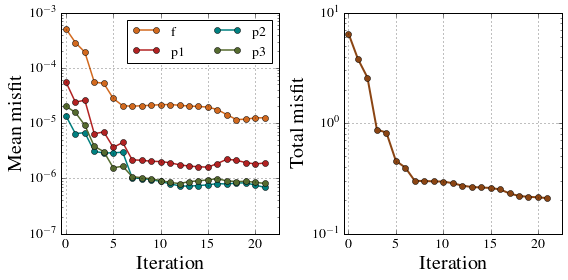

In [12]:
#~ Get ridges used
ridges=read_params.get_modes_used()
modes={'0':'fmode'}
for i in xrange(1,8): modes[str(i)]='p'+str(i)+'mode'
modes['8']='first_bounce_pmode'

datadir = read_params.get_directory()
updatedir = os.path.join(datadir,"update")

#~ Get source location, useful if plotting sourcewise misfit (data_sourcewise)
srclocs = np.loadtxt(os.path.join(datadir,'master.pixels'),ndmin=1)
num_source = len(srclocs)

#~ Get a list of misfit files in the update directory
misfitfiles=sorted([os.path.join(datadir,"update",f) for f in 
                    fnmatch.filter(os.listdir(os.path.join(datadir,"update")),'misfit_[0-9][0-9]')])

num_misfit_files=len(misfitfiles)

markers = iter(('o', 'v', '8','s','<', 7, '*', 'h', '^', 'D', 'd'))
colors = iter(('chocolate','firebrick','teal','darkolivegreen','purple','darkblue','saddlebrown'))
linestyles = itertools.cycle(('solid','dashed','dotted'))
modemisfit = np.zeros((len(ridges),num_misfit_files))

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Times']})

plt.subplot(121)

for ridgeno,ridge in enumerate(ridges[:4]):

    nsources_found = 0

    for src in xrange(1,num_source+1):

        for iterno in xrange(num_misfit_files):

            ttfile = os.path.join(datadir,'tt','iter'+str(iterno).zfill(2),
                        'ttdiff_src'+str(src).zfill(2)+'.'+modes[ridge])
            try:
                tt=np.loadtxt(ttfile)
                npix = tt.shape[0]
                modemisfit[ridgeno,iterno] += sum((tt[:,1]/60)**2)/npix
                nsources_found+=1
            except IOError:
                pass

    modemisfit[ridgeno] /= nsources_found            

    plt.semilogy(range(num_misfit_files),modemisfit[ridgeno],marker='o',color=next(colors),
    ls='solid',linewidth=1.5,label=modes[ridge][:-4])

plt.tick_params(axis='both', which='major', labelsize=14)    
plt.xlim(-0.5,num_misfit_files+0.5)
plt.xlabel("Iteration",fontsize=20)
plt.ylabel('Mean misfit',fontsize=20)  
plt.legend(ncol=2,loc="best",fontsize=14)
plt.grid()

# plt.subplot(122)
# for ridgeno,ridge in enumerate(ridges[4:]):

#     nsources_found = 0

#     for src in xrange(1,num_source+1):

#         for iterno in xrange(num_misfit_files):

#             ttfile = os.path.join(datadir,'tt','iter'+str(iterno).zfill(2),
#                         'ttdiff_src'+str(src).zfill(2)+'.'+modes[ridge])
#             try:
#                 tt=np.loadtxt(ttfile)
#                 npix = tt.shape[0]
#                 modemisfit[ridgeno,iterno] += sum((tt[:,1]/60)**2)/npix
#                 nsources_found+=1
#             except IOError:
#                 pass

#     modemisfit[ridgeno] /= nsources_found            

#     plt.semilogy(range(num_misfit_files),modemisfit[ridgeno],marker=next(markers),color='black',
#     ls=next(linestyles),label=modes[ridge][:-4])

# plt.tick_params(axis='both', which='major', labelsize=14)
# plt.xlim(-0.5,num_misfit_files+5)
# plt.xlabel("Iteration",fontsize=20)
# plt.ylabel('Mean Misfit',fontsize=20)
# plt.legend(ncol=2)


total_misfit = np.zeros(num_misfit_files)
for fileno,misfitfile in enumerate(misfitfiles):
    total_misfit[fileno] = np.sum(np.loadtxt(misfitfile,usecols=[2]))

ax2=plt.subplot(122)

plt.semilogy(range(num_misfit_files),total_misfit,color='saddlebrown',marker='o',ls='solid',linewidth=2)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(-0.5,num_misfit_files+0.5)
plt.xlabel("Iteration",fontsize=20)
plt.ylabel('Total misfit',fontsize=20)
ax2.grid()

plt.gcf().set_size_inches(8,4)

plt.tight_layout()

if not os.path.exists('plots'): os.makedirs('plots')
plt.savefig('plots/data_misfit.eps',bbox_inches='tight')

## Waveform mismatch

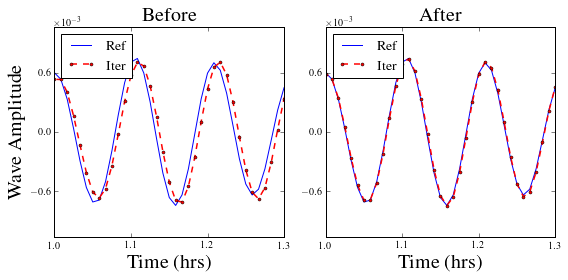

In [13]:
src=4
true_wavefield = fitsread(os.path.join(datadir,"tt","data","data"+str(src).zfill(2)+".fits"))
nt = true_wavefield.shape[0]
t = np.arange(nt)*dt
starting_wavefield = fitsread(os.path.join(datadir,"tt","iter00","vz_cc_src"+str(src).zfill(2)+".fits"))
iterated_wavefield = fitsread(os.path.join(datadir,"tt","iter14","vz_cc_src"+str(src).zfill(2)+".fits"))
fmode_filter = fitsread('fmode_filter.fits')
true_fmode_waveform = np.fft.ifft2(np.fft.fft2(true_wavefield)*fmode_filter).real
starting_fmode_waveform = np.fft.ifft2(np.fft.fft2(starting_wavefield)*fmode_filter).real
iterated_fmode_waveform = np.fft.ifft2(np.fft.fft2(iterated_wavefield)*fmode_filter).real

receiver_dist = 30
t_span_low = 1
t_span_high = 1.3
def ind_rec(receiver_dist):
    receiver_loc=x[abs(x-(src_loc+receiver_dist)).argmin()]
    return int((receiver_loc/Lx+0.5)*nx)

ax1=plt.subplot(121)
plt.plot(t/3600,true_fmode_waveform[:,ind_rec(receiver_dist)],label="Ref");
plt.plot(t/3600,starting_fmode_waveform[:,ind_rec(receiver_dist)],
        ls="dashed",lw=1.5,color="red",label="Iter",marker='o',ms=3);
ax1.xaxis.set_major_locator(MaxNLocator(4))
ax1.yaxis.set_major_locator(MaxNLocator(4))
plt.ticklabel_format(style="sci",scilimits=(0,0),axis="y")
plt.legend(loc="upper left",fontsize=14)

plt.ylabel("Wave Amplitude",fontsize=20);
plt.xlabel("Time (hrs)",fontsize=20)

plt.xlim(t_span_low,t_span_high);
plt.ylim(starting_fmode_waveform[:,ind_rec(receiver_dist)].min()*1.5,
         starting_fmode_waveform[:,ind_rec(receiver_dist)].max()*1.5);
plt.title("Before",fontsize=20,y=1.01)

ax1=plt.subplot(122)
plt.plot(t/3600,true_fmode_waveform[:,ind_rec(receiver_dist)],label="Ref");
plt.plot(t/3600,iterated_fmode_waveform[:,ind_rec(receiver_dist)],
         ls="dashed",lw=1.5,color="red",label="Iter",marker='o',ms=3);
ax1.xaxis.set_major_locator(MaxNLocator(4))
ax1.yaxis.set_major_locator(MaxNLocator(4))
plt.ticklabel_format(style="sci",scilimits=(0,0),axis="y")
plt.legend(loc="upper left",fontsize=14)

plt.xlabel("Time (hrs)",fontsize=20)

plt.xlim(t_span_low,t_span_high);
plt.ylim(starting_fmode_waveform[:,ind_rec(receiver_dist)].min()*1.5,
         starting_fmode_waveform[:,ind_rec(receiver_dist)].max()*1.5);
plt.title("After",fontsize=20,y=1.01);

plt.gcf().set_size_inches(8,4)
plt.tight_layout()

if not os.path.exists('plots'): os.makedirs('plots')
plt.savefig('plots/waveform_misfit.eps',bbox_inches='tight')

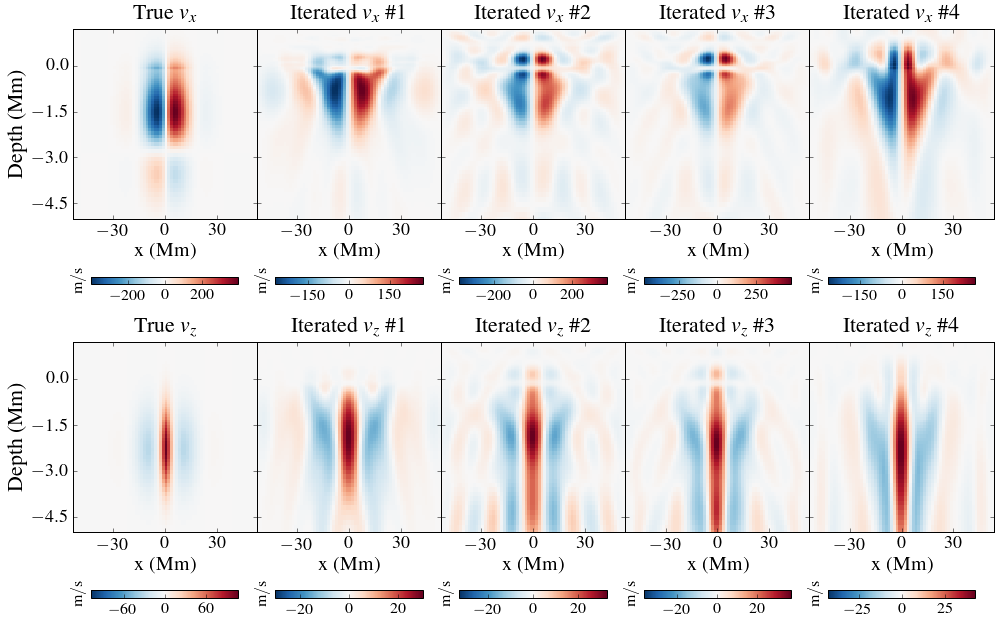

In [4]:
datadir=read_params.get_directory()
parentdir = os.path.dirname(datadir)
strategydir=[os.path.join(parentdir,modeldir) 
             for modeldir in ("f_to_p1_512_4hr_hsmooth30",
                              "f_to_p3_512_4hr_hsmooth30",
                              "f_to_p7_512_4hr_hsmooth30_vsmooth2",
                              "f_to_p7_512_4hr_hsmooth30_vsmooth8")]

Lx=read_params.get_xlength()
nx=read_params.get_nx()
x=np.linspace(-Lx/2,Lx/2,num=nx,endpoint=False)
dx = x[1]-x[0]
x_plot = np.append(x-dx/2,x[-1]+dx/2)

Rsun=695.8
z=np.loadtxt(read_params.get_solarmodel(),usecols=[0])
z=(z-1)*Rsun
z_pixels = np.arange(len(z))
z_plot = np.interp(z_pixels[:-1]+0.5,z_pixels,z)
z_plot = np.append(z[0]-(z[1]-z[0])/2,np.append(z_plot,z[-1]+(z[-1]-z[-2])/2))


def forceAspect(ax,aspect=1):
    extent =  ax.get_xlim()+ax.get_ylim()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

true_vx = fitsread('true_vx.fits')
true_vz = fitsread('true_vz.fits')

cblist = []
axlist=[]
def add_subplot(sp_index,array,title=""):
    row_ind,col_ind=sp_index
    ax=plt.subplot(2,5,row_ind*5+col_ind+1)
    array_max = abs(array).max()
    qm=ax.pcolorfast(x_plot,z_plot,array,vmax=array_max,vmin=-array_max,cmap="RdBu_r")
    cb=plt.colorbar(mappable=qm,orientation="horizontal",shrink=0.8,pad=0.2,ticks=MaxNLocator(5))
    plt.title(title,y=1.01,fontsize=22)
    cblist.append(cb)
    axlist.append(ax)
    ax.set_xlim(-Lx/15,Lx/15)
    ax.set_ylim(-5,z_plot.max())
    ax.set_xlabel("x (Mm)",fontsize=20)
    ax.xaxis.set_major_locator(MaxNLocator(4,prune="both"))
    ax.yaxis.set_major_locator(MaxNLocator(5,prune="both"))
    ax.tick_params(axis='both', labelsize=18)
    plt.setp(ax.get_yticklabels(),visible=False)

add_subplot((0,0),true_vx,title="True $v_x$")
add_subplot((1,0),true_vz,title="True $v_z$")

#######################################################################################################

itercutoff = [15,20,20,20]


for strategy_index,datadir in enumerate(strategydir):

    current_vx = fitsread(os.path.join(strategydir[strategy_index],'update','vx_'+str(itercutoff[strategy_index])+'.fits'))
    current_vz = fitsread(os.path.join(strategydir[strategy_index],'update','vz_'+str(itercutoff[strategy_index])+'.fits'))

    add_subplot((0,strategy_index+1),current_vx,title="Iterated $v_x$ \#$"+str(strategy_index+1)+"$")
    add_subplot((1,strategy_index+1),current_vz,title="Iterated $v_z$ \#$"+str(strategy_index+1)+"$")


axlist[0].set_ylabel("Depth (Mm)",fontsize=22)
axlist[1].set_ylabel("Depth (Mm)",fontsize=22)
plt.setp(axlist[0].get_yticklabels(),visible=True)
plt.setp(axlist[1].get_yticklabels(),visible=True)
    
for cb in cblist: 
    cb.ax.set_ylabel("$\mathrm{m}/\mathrm{s}$",rotation=90,fontsize=16)
    cb.ax.tick_params(axis="x",labelsize=16)

#################################################################################

fig=plt.gcf()
fig.set_size_inches(14,9)
plt.tight_layout()
plt.subplots_adjust(wspace=0.)

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/iterated_vel_strategies.eps")

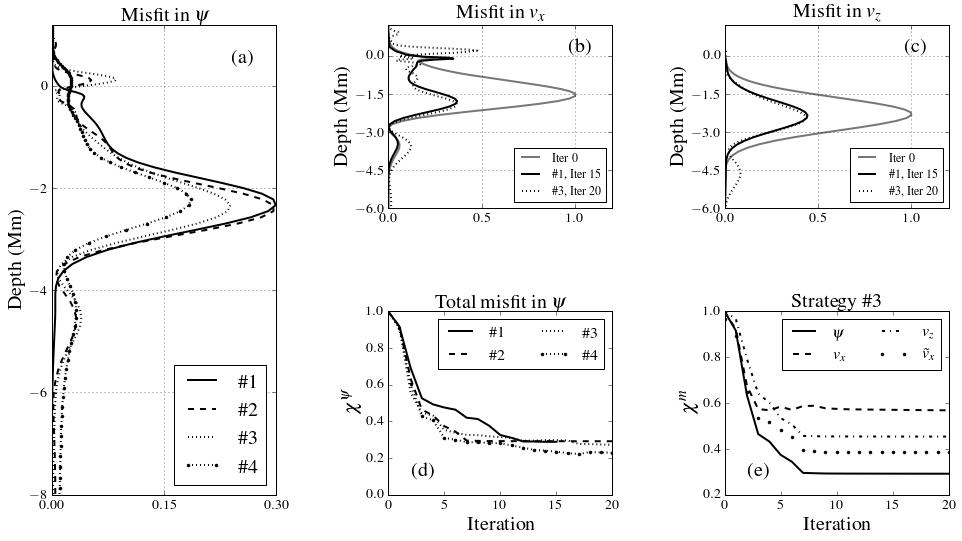

In [21]:
strategydir=("f_to_p1_512_4hr_hsmooth30","f_to_p3_512_4hr_hsmooth30",
            "f_to_p7_512_4hr_hsmooth30_vsmooth2","f_to_p7_512_4hr_hsmooth30_vsmooth8")

def model_misfit_depth(directory,iterno=None,var="psi"):
    datadir = os.path.join(os.path.dirname(read_params.get_directory()),directory)
    true_model = np.squeeze(pyfits.getdata("true_"+var+".fits"))
    updatedir = os.path.join(datadir,"update")
    if var=="psi":
        iter_model_list = sorted(fnmatch.filter(os.listdir(updatedir),"model_psi_[0-9][0-9].fits"))
    else:
        iter_model_list = sorted(fnmatch.filter(os.listdir(updatedir),var+"_[0-9][0-9].fits"))
        
    if iterno is None: iter_model_name = iter_model_list[-1]; iterno=len(iter_model_list)
    else: iter_model_name = iter_model_list[iterno]
    iterated_model = np.squeeze(pyfits.getdata(os.path.join(datadir,"update",iter_model_name)))
    iterated_model -= iterated_model[0,0]

    true_misfit = np.trapz(true_model**2,x=x,axis=1)
    iter_misfit = np.trapz((true_model-iterated_model)**2,x=x,axis=1)
    return true_misfit/true_misfit.max(),iter_misfit/true_misfit.max(),iterno

def plot_misfit_z(misfit,**kwargs):
    plt.plot(misfit,z,linewidth=2,color=kwargs.pop("color","black"),**kwargs)
    plt.ylim(-8.,z[-1])
    ax.xaxis.set_major_locator(MaxNLocator(3))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.grid(True)

def model_misfit_strategy(directory,itercutoff=None):
    datadir = os.path.join(os.path.dirname(read_params.get_directory()),directory)
    true_model = np.squeeze(pyfits.getdata("true_psi.fits"))
    updatedir = os.path.join(datadir,"update")
    iter_model_list = sorted(fnmatch.filter(os.listdir(updatedir),"model_psi_[0-9][0-9].fits"))
    
    misfit = []
    true_misfit = np.sum(true_model**2)
    for model_name in iter_model_list:
        iter_model = np.squeeze(pyfits.getdata(os.path.join(updatedir,model_name)))
        iter_model -= iter_model[0,0]
        misfit.append( np.sum((true_model - iter_model)**2)/true_misfit)
        
    return misfit if itercutoff is None else misfit[:itercutoff+1]
    
def model_misfit_psi_v(directory,itercutoff=None,below_surf=False):
    datadir = os.path.join(os.path.dirname(read_params.get_directory()),directory)
    updatedir = os.path.join(datadir,"update")
    true_model = np.squeeze(pyfits.getdata("true_psi.fits"))
    iter_model_list = sorted(fnmatch.filter(os.listdir(updatedir),"model_psi_[0-9][0-9].fits"))
    if itercutoff is not None: iter_model_list=iter_model_list[:itercutoff+1]
    misfit_psi = []
    true_misfit = np.sum(true_model**2)
    for model_name in iter_model_list:
        iter_model = np.squeeze(pyfits.getdata(os.path.join(updatedir,model_name)))
        iter_model -= iter_model[0,0]
        squared_diff = (true_model - iter_model)**2
        if below_surf: squared_diff[z>0]=0
        misfit_psi.append( np.sum(squared_diff)/true_misfit)
        
    true_model = np.squeeze(pyfits.getdata("true_vz.fits"))
    iter_model_list = sorted(fnmatch.filter(os.listdir(updatedir),"vz_[0-9][0-9].fits"))
    if itercutoff is not None: iter_model_list=iter_model_list[:itercutoff+1]
    misfit_vz = []
    true_misfit = np.sum(true_model**2)
    for model_name in iter_model_list:
        iter_model = np.squeeze(pyfits.getdata(os.path.join(updatedir,model_name)))
        squared_diff = (true_model - iter_model)**2
        if below_surf: squared_diff[z>0]=0
        misfit_vz.append( np.sum(squared_diff)/true_misfit)
    
    
    true_model = np.squeeze(pyfits.getdata("true_vx.fits"))
    iter_model_list = sorted(fnmatch.filter(os.listdir(updatedir),"vx_[0-9][0-9].fits"))
    if itercutoff is not None: iter_model_list=iter_model_list[:itercutoff+1]
    misfit_vx = []
    true_misfit = np.sum(true_model**2)
    for model_name in iter_model_list:
        iter_model = np.squeeze(pyfits.getdata(os.path.join(updatedir,model_name)))
        squared_diff = (true_model - iter_model)**2
        if below_surf: squared_diff[z>0]=0
        misfit_vx.append( np.sum(squared_diff)/true_misfit)
        
    return misfit_psi,misfit_vx,misfit_vz
    
ax=plt.subplot2grid((2,3),(0,0),rowspan=2)
plot_misfit_z(model_misfit_depth(strategydir[0])[1],ls="solid",label=r"$\# 1$")
plot_misfit_z(model_misfit_depth(strategydir[1],iterno=20)[1],ls="dashed",label=r"$\# 2$")
plot_misfit_z(model_misfit_depth(strategydir[2],iterno=20)[1],ls="dotted",label=r"$\# 3$")
plot_misfit_z(model_misfit_depth(strategydir[3],iterno=20)[1],ls="dotted",label=r"$\# 4$",marker='o',markersize=3)
plt.legend(loc="lower right",fontsize=20)
plt.ylabel("Depth (Mm)",fontsize=20)
plt.title("Misfit in $\psi$",fontsize=20)
plt.tick_params(axis="both",labelsize=14)
plt.text(0.8,0.92,"(a)",transform=ax.transAxes,fontsize=20,weight="bold")

ax=plt.subplot2grid((2,3),(0,1))
true_misfit,iter_misfit,iterno = model_misfit_depth(strategydir[0],iterno=15,var="vx")
plot_misfit_z(true_misfit,ls="solid",color="#777777",label="Iter 0")
plot_misfit_z(iter_misfit,ls="solid",label="$\# 1$, Iter "+str(iterno))
true_misfit,iter_misfit,iterno = model_misfit_depth(strategydir[1],iterno=20,var="vx")
plot_misfit_z(iter_misfit,ls="dotted",label="$\# 3$, Iter "+str(iterno))
plt.ylabel("Depth (Mm)",fontsize=20)
plt.title("Misfit in $v_x$",fontsize=20)
plt.tick_params(axis="both",labelsize=14)
plt.ylim(-6,z[-1])
plt.legend(loc="lower right")
plt.text(0.8,0.85,"(b)",transform=ax.transAxes,fontsize=20,weight="bold")

ax=plt.subplot2grid((2,3),(0,2))
true_misfit,iter_misfit,iterno = model_misfit_depth(strategydir[0],iterno=15,var="vz")
plot_misfit_z(true_misfit,ls="solid",color="#777777",label="Iter 0")
plot_misfit_z(iter_misfit,ls="solid",label="$\# 1$, Iter "+str(iterno))
true_misfit,iter_misfit,iterno = model_misfit_depth(strategydir[1],iterno=20,var="vz")
plot_misfit_z(iter_misfit,ls="dotted",label="$\# 3$, Iter "+str(iterno))
plt.title("Misfit in $v_z$",fontsize=20)
plt.ylabel("Depth (Mm)",fontsize=20)
plt.ylim(-6,z[-1])
plt.legend(loc="lower right")
plt.tick_params(axis="both",labelsize=14)
plt.text(0.8,0.85,"(c)",transform=ax.transAxes,fontsize=20,weight="bold")

ax=plt.subplot2grid((2,3),(1,1))
plt.plot(model_misfit_strategy(strategydir[0]),color="black",ls="solid",linewidth=2,label=r"$\# 1$")
plt.plot(model_misfit_strategy(strategydir[1],itercutoff=20),color="black",ls="dashed",linewidth=2,label=r"$\# 2$")
plt.plot(model_misfit_strategy(strategydir[2],itercutoff=20),color="black",ls="dotted",linewidth=2,label=r"$\# 3$")
plt.plot(model_misfit_strategy(strategydir[3],itercutoff=20),color="black",
         ls="dotted",linewidth=2,label=r"$\# 4$",marker='o',markersize=3)
plt.ylim(0,1)
ax.yaxis.set_major_locator(MaxNLocator(5))
plt.legend(loc="upper right",ncol=2,fontsize=16)
plt.title("Total misfit in $\psi$",fontsize=20)
plt.xlabel("Iteration",fontsize=20)
plt.ylabel("$\chi^{\psi}$",fontsize=20)
plt.tick_params(axis="both",labelsize=14)
plt.text(0.1,0.1,"(d)",transform=ax.transAxes,fontsize=20,weight="bold")

ax=plt.subplot2grid((2,3),(1,2))
misfit_psi,misfit_vx,misfit_vz=model_misfit_psi_v(strategydir[1],itercutoff=20)
plt.plot(misfit_psi,color="black",linestyle="solid",linewidth=2,label="$\psi$")
plt.plot(misfit_vx,color="black",linestyle="dashed",linewidth=2,label="$v_x$")
plt.plot(misfit_vz,color="black",linestyle="dashdot",linewidth=2,label="$v_z$")
misfit_psi,misfit_vx,misfit_vz=model_misfit_psi_v(strategydir[1],itercutoff=20,below_surf=True)
plt.plot(misfit_vx,color="black",linestyle="None",marker="o",markersize=3,label=r"$\tilde{v}_x$")
plt.ylim(0.2,1)
ax.yaxis.set_major_locator(MaxNLocator(5))
plt.legend(loc="upper right",ncol=2,fontsize=16)
plt.title("Strategy $\# 3$",fontsize=20)
plt.xlabel("Iteration",fontsize=20)
plt.ylabel("$\chi^m$",fontsize=20)
plt.tick_params(axis="both",labelsize=14)
plt.text(0.1,0.1,"(e)",transform=ax.transAxes,fontsize=20,weight="bold")

plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.gcf().set_size_inches(15,9)
if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/strategy_comp.eps")

## Data Misfit

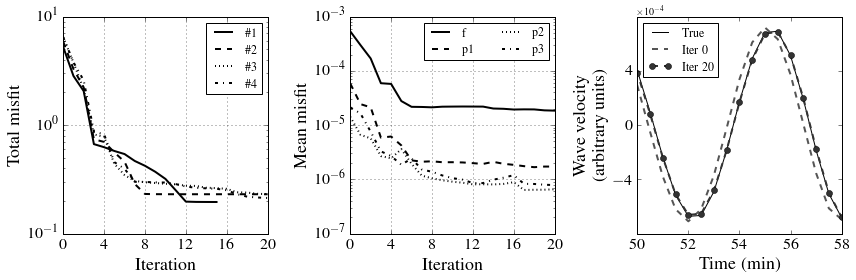

In [3]:
datadir = read_params.get_directory()
parentdir = os.path.dirname(datadir)
updatedir = os.path.join(datadir,"update")
strategydir=[os.path.join(parentdir,modeldir) for modeldir in 
            ("f_to_p1_512_4hr_hsmooth30","f_to_p3_512_4hr_hsmooth30",
            "f_to_p7_512_4hr_hsmooth30_vsmooth2","f_to_p7_512_4hr_hsmooth30_vsmooth8")]

ridges=read_params.get_modes_used()
modes={'0':'fmode'}
for i in xrange(1,8): modes[str(i)]='p'+str(i)+'mode'
modes['8']='first_bounce_pmode'

mp=np.loadtxt(os.path.join(datadir,'master.pixels'),ndmin=1)
number_of_sources = len(mp)

#~ First panel, compare different strategies
linestyles = itertools.cycle(('solid','dashed','dotted','dashdot'))
strategylabel = iter(["$\#$"+str(i) for i in xrange(1,5)])
itercutoff=20
ax=plt.subplot(131)
for directory in strategydir:
    misfitfiles = fnmatch.filter(os.listdir(os.path.join(directory,"update")),'misfit_[0-9][0-9]')
    misfitfiles=sorted([os.path.join(directory,"update",f) for f in misfitfiles])[:itercutoff+1]
    total_misfit = np.zeros(len(misfitfiles))
    for fileno,misfitfile in enumerate(misfitfiles):
        total_misfit[fileno] = np.sum(np.loadtxt(misfitfile,usecols=[2]))
        
    plt.semilogy(total_misfit,color='black',ls=next(linestyles),linewidth=2,label=next(strategylabel))

ax.xaxis.set_major_locator(MaxNLocator(5))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel("Iteration",fontsize=18)
plt.ylabel('Total misfit',fontsize=18)
plt.legend()
plt.tick_params(axis="both",labelsize=16)
ax.grid()

#~ Second panel, different ridges for one strategy
misfitfiles=sorted([os.path.join(updatedir,f) for f in fnmatch.filter(os.listdir(updatedir),'misfit_[0-9][0-9]')])
itercutoff = 20
itercutoff = min(len(misfitfiles),itercutoff)
modemisfit = np.zeros((len(ridges),itercutoff+1))
ax=plt.subplot(132)
linestyles = itertools.cycle(('solid','dashed','dotted','dashdot'))
for ridgeno,ridge in enumerate(ridges[:4]):
    
    nsources_found = 0
    
    for src in xrange(1,number_of_sources+1):
        
        for iterno in xrange(itercutoff+1):
        
            ttfile = os.path.join(strategydir[2],'tt','iter'+str(iterno).zfill(2),
                        'ttdiff_src'+str(src).zfill(2)+'.'+modes[ridge])
            try:
                tt=np.loadtxt(ttfile)
                npix = tt.shape[0]
                modemisfit[ridgeno,iterno] += sum((tt[:,1]/60)**2)/npix
                nsources_found+=1
            except IOError:
                pass
            
    modemisfit[ridgeno] /= nsources_found            

    plt.semilogy(modemisfit[ridgeno],color='black',ls=next(linestyles),label=modes[ridge][:-4],linewidth=2)
   
ax.xaxis.set_major_locator(MaxNLocator(5))
plt.tick_params(axis='both', which='major', labelsize=16)    
plt.xlabel("Iteration",fontsize=18)
plt.ylabel('Mean misfit',fontsize=18)  
plt.legend(ncol=2)
plt.tick_params(axis="both",labelsize=16)
ax.grid()


#~ Third panel, waveforms
ax=plt.subplot(133)
datadir = strategydir[2]
src = read_params.parse_cmd_line_params("src",mapto=int,default=1)
srcloc = mp[src-1]
data=fitsread(os.path.join(datadir,'tt','data','data'+str(src).zfill(2)+'.fits'))
nt,nx = data.shape
filt = fitsread('fmode_filter.fits')
data_filtered = np.fft.ifft2(np.fft.fft2(data)*filt).real

vzcc_start = fitsread(os.path.join(datadir,"tt","iter00","vz_cc_src"+str(src).zfill(2)+".fits"))
vzcc_start_filtered = np.fft.ifft2(np.fft.fft2(vzcc_start)*filt).real

iterdirs = sorted(glob.glob(os.path.join(datadir,'tt','iter*')))
itercutoff = 20
iter_dir = iterdirs[min(itercutoff,len(iterdirs)-1)]
iter_to_plot = iter_dir[-2:]
vzcc_iter = fitsread(os.path.join(iter_dir,'vz_cc_src'+str(src).zfill(2)+'.fits'))
vzcc_iter_filtered = np.fft.ifft2(np.fft.fft2(vzcc_iter)*filt).real

#~ Try to load tt file
ttfile = os.path.join(iter_dir,'ttdiff_src'+str(src).zfill(2)+'.fmode')
ttdiff_array = np.loadtxt(ttfile)
pixel_ttdiff = ttdiff_array[:,0]
lef_ttdiff = ttdiff_array[:,2]
rig_ttdiff = ttdiff_array[:,3]

Lx = read_params.get_xlength()
dt = read_params.get_dt()

t = np.arange(nt)*dt/60.

def dist_to_pix(dist): return int((dist+Lx/2+srcloc)/Lx*nx)
def pix_to_dist(pix): return (pix-nx/2)/nx*Lx-srcloc
pix = dist_to_pix(20.)

lef_ttdiff_cutoff = t[map(int,lef_ttdiff[pixel_ttdiff==pix])]
rig_ttdiff_cutoff = t[map(int,rig_ttdiff[pixel_ttdiff==pix])]

plt.plot(t,data_filtered[:,pix],label="True",color='black')
plt.plot(t,vzcc_start_filtered[:,pix],label="Iter 0",linestyle='dashed',linewidth=2,color='#555555')
plt.plot(t,vzcc_iter_filtered[:,pix],label="Iter "+iter_to_plot,linestyle='dashed',linewidth=2,color='#333333',marker='o')
ax.yaxis.set_major_locator(MaxNLocator(4,prune='both'))
yaxis_formatter = ScalarFormatter(useMathText=False)
#~ yaxis_formatter = ScalarFormatter(useMathText=True)
yaxis_formatter.set_scientific(True)
yaxis_formatter.set_powerlimits((0,0))
ax.yaxis.set_major_formatter(yaxis_formatter)
ax.xaxis.set_major_locator(MaxNLocator(5))

plt.ylabel("Wave velocity\n(arbitrary units)",fontsize=18)
plt.tick_params(axis="both",labelsize=16)
    
xlim_left = lef_ttdiff_cutoff
xlim_right = rig_ttdiff_cutoff
plt.xlim(xlim_left,xlim_right)
plt.legend(loc='best')

plt.xlabel("Time (min)",fontsize=18)

plt.gcf().set_size_inches(12,4)
plt.tight_layout()

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/data_misfit.eps")

## Travel time misfit at receivers

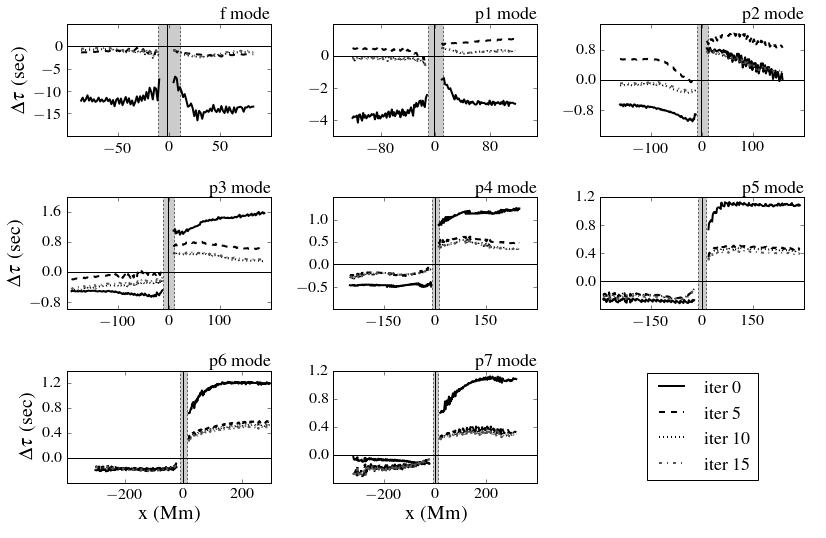

In [7]:
datadir=read_params.get_directory()
masterpixelsfile=os.path.join(datadir,'master.pixels')
masterpixels=np.loadtxt(masterpixelsfile,ndmin=1)

dt=read_params.get_dt()/60.

src = read_params.parse_cmd_line_params("src",mapto=int,default=4)
itercutoff = read_params.parse_cmd_line_params("iter",mapto=int,default=np.inf)

if src>len(masterpixels): src=len(masterpixels)
src=str(src).zfill(2)


nx=read_params.get_nx()
Lx=read_params.get_xlength()
x=np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
nz = read_params.get_nz()

flows = read_params.if_flows()
sound_speed_perturbed = read_params.if_soundspeed_perturbed()

#~ Read in velocity and compute length scales

vx=fitsread('true_vx.fits')
vx_max_row_index,vx_max_col_index = divmod(vx.argmax(),nx)
vx_max_row = vx[vx_max_row_index]
vx=None
vxmax=vx_max_row.max()
hwhm=np.where(vx_max_row>vxmax/2)[0][-1]-nx//2

perturbation_left_limit,perturbation_right_limit=x[nx//2-hwhm],x[nx//2+hwhm]

datafile=os.path.join(datadir,'forward_src'+src+'_ls00','data.fits')
data=fitsread(datafile)
nt=data.shape[0]
time=np.arange(nt)*dt

modes={'0':'fmode'}
for pmodeno in xrange(1,8): modes.update({str(pmodeno):'p'+str(pmodeno)+'mode'})
modes['8']="first_bounce_pmode"
ridge_filters=sorted(read_params.get_modes_used())

def spaced(a): 
    b=a[:-4]+" "+a[-4:]
    b=b.replace("_"," ")
    return b

vzcc=[]
vzcc_ridges=[]
iters=[]

srcloc=masterpixels[int(src)-1]
srcloc_ind=np.argmin(abs(x-srcloc))
srcloc=round(x[srcloc_ind],1)

ttdiff_ridges={}
for mode in modes: ttdiff_ridges.update({mode:{"iter_no":[],"misfits":[]}})
for iteration_no in xrange(0,100):
    ttpath=os.path.join(datadir,'tt','iter'+str(iteration_no).zfill(2))
    if os.path.exists(ttpath):
        for modeno,mode in enumerate(ridge_filters):
            ttfile=os.path.join(ttpath,'ttdiff_src'+src+'.'+modes[mode])
            if os.path.exists(ttfile):
                ttdiff_ridges[mode]["iter_no"].append(iteration_no)
                ttdiff_ridges[mode]["misfits"].append(np.loadtxt(ttfile))

#~ The actual plotting stuff
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Times'],'size':24})

modes_to_plot=min(8,len(ridge_filters))

subplot_layout=plotc.layout_subplots(len(ridge_filters[:modes_to_plot]))[:2]

tdfig,tdiffaxes=plt.subplots(*subplot_layout)
tdiffaxes=np.array(list([tdiffaxes])).flatten()

c=['black','#555555','#888888']

iters_to_plot = [0,5,10,15]

for modeno,mode in enumerate(ridge_filters[:modes_to_plot]):
    num_iterations=min(itercutoff,len(ttdiff_ridges[mode]["iter_no"]))
    # If there are fewer iterations than max(iters_to_plot), choose only ones available
    iters_to_plot_ridge = [i for i in iters_to_plot if i<num_iterations]
    
    linestyles = itertools.cycle(('solid','dashed','dotted','dashdot'))
    
    for color_index,iter_index in enumerate(iters_to_plot_ridge):
        
        index_of_iteration=ttdiff_ridges[mode]["iter_no"].index(iter_index)
        td=ttdiff_ridges[mode]["misfits"][index_of_iteration]
        td[:,0]-=1 # fortran index starts from 1, change to python zero based index
        
        left_pix=np.where(td[:,0]<srcloc_ind)[0]
        xcoords_left=np.take(x,td[left_pix,0].astype(int))
        right_pix=np.where(td[:,0]>srcloc_ind)[0]
        xcoords_right=np.take(x,td[right_pix,0].astype(int))    
        
        ax=tdiffaxes[modeno]        
        
        #~ Points to the left
        skip_pix = 1
        ls = next(linestyles)
        ax.plot(xcoords_left[::skip_pix],td[left_pix[::skip_pix],1],color=c[color_index//3],
                    label="iter "+str(iter_index),linestyle=ls,linewidth=2)

        #~ Points to the right
        ax.plot(xcoords_right[::skip_pix],td[right_pix[::skip_pix],1],color=c[color_index//3],linestyle=ls,linewidth=2)

        #~ Zero misfit line
        ax.axhline(y=[0],ls='-',color='black')
        
        ax.set_title(spaced(modes[mode]),fontsize=18,loc='right')
        
        
for ax_no in xrange(0,len(tdiffaxes),subplot_layout[1]):
    tdiffaxes[ax_no].set_ylabel(r"$\Delta \tau$ (sec)",fontsize=20)

for ax_no in xrange(subplot_layout[1]*(subplot_layout[0]-1),len(tdiffaxes)):    
    tdiffaxes[ax_no].set_xlabel("x (Mm)",fontsize=20)
    
   
for ax_ind,ax in enumerate(tdiffaxes):
    if ax_ind>= modes_to_plot: 
        ax.axis('off')
        continue
    #~ Source location line
    ax.axvline(x=srcloc,color='black')
    #~ Rectangle with border
    ax.axvline(x=perturbation_left_limit,ls='dotted',color='black')
    ax.axvline(x=perturbation_right_limit,ls='dotted',color='black')
    ax.axvspan(perturbation_left_limit,perturbation_right_limit,color='#CCCCCC')
    ax.xaxis.set_major_locator(MaxNLocator(4,prune="both"))
    ax.yaxis.set_major_locator(MaxNLocator(5,prune='both'))
    ax.xaxis.set_tick_params(which='major', labelsize=16)
    ax.yaxis.set_tick_params(which='major', labelsize=16)

if modes_to_plot<np.prod(subplot_layout):
    # This means that there are empty subplots
    # Place legend in empty spot
    handles,labels = tdiffaxes[0].get_legend_handles_labels()
    tdiffaxes[-1].legend(handles,labels,loc="center",fontsize=18)
else:
    for ax in tdiffaxes[:modes_to_plot]: ax.legend(loc="best")

tdfig.tight_layout()
plt.subplots_adjust(wspace=0.3)

plt.gcf().set_size_inches(12,8)
plt.tight_layout()

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/tt_misfit_receiver.eps")

## Single mode data misfit

In [6]:
datadir=read_params.get_directory()
masterpixels=np.loadtxt(os.path.join(datadir,'master.pixels'),ndmin=1)
nsrc = len(masterpixels)


nx=read_params.get_nx()
Lx=read_params.get_xlength()
x=np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
nz = read_params.get_nz()

#~ Read in velocity and compute length scales

vx=fitsread('true_vx.fits')
vx_max_row_index,vx_max_col_index = divmod(vx.argmax(),nx)
vx_max_row = vx[vx_max_row_index]
vx=None
vxmax=vx_max_row.max()
hwhm=np.where(vx_max_row>vxmax/2)[0][-1]-nx//2

perturbation_left_limit,perturbation_right_limit=x[nx//2-hwhm],x[nx//2+hwhm]

src = 6


modes={'0':'f'}
for i in xrange(1,8): modes[str(i)]='p'+str(i)
mode_used = modes[read_params.get_modes_used()[0]]
mode_freq_ranges = {"f":(2,3),
"p1":(2.7,4.2),"p2":(3.1,5.2),"p3":(3.4,5.8),"p4":(3,6),"p5":(3.5,6),"p6":(3.5,6),"p7":(3.5,6)}
full_freq_range = mode_freq_ranges[mode_used]

iters_done = len(os.listdir(os.path.join(datadir,"tt")))

for src in xrange(1,nsrc+1):
    srcloc=masterpixels[src-1]
    srcloc_ind=np.argmin(abs(x-srcloc))
    srcloc=round(x[srcloc_ind],1)
    num_freq_ranges = 4
    for freq_ind in xrange(num_freq_ranges):
        linestyles = itertools.cycle(('solid','dashed','dotted','dashdot'))
        c=itertools.cycle(['black','#555555'])
        plt.subplot(2,2,freq_ind+1)
        for iter_index in np.linspace(0,iters_done,3,endpoint=False).astype(int):
            td=np.loadtxt(os.path.join(datadir,"tt","iter"+str(iter_index).zfill(2),"ttdiff_src"+
                                       str(src).zfill(2)+"."+mode_used+"mode."+str(freq_ind)))
            td[:,0]-=1 # fortran index starts from 1, change to python zero based index

            left_pix=np.where(td[:,0]<srcloc_ind)[0]
            xcoords_left=np.take(x,td[left_pix,0].astype(int))
            right_pix=np.where(td[:,0]>srcloc_ind)[0]
            xcoords_right=np.take(x,td[right_pix,0].astype(int))

            #~ Points to the left
            skip_pix = 1
            ls = next(linestyles)
            color=next(c)
            plt.plot(xcoords_left[::skip_pix],td[left_pix[::skip_pix],1],color=color,
                        label=" {:d} : {:.1f}".format(iter_index,sum((td[:,1]/60)**2)/2),linestyle=ls,linewidth=2)

            #~ Points to the right
            plt.plot(xcoords_right[::skip_pix],td[right_pix[::skip_pix],1],color=color,linestyle=ls,linewidth=2)

            #~ Zero misfit line
            plt.axhline(y=[0],ls='-',color='black')

        freq_low = full_freq_range[0]+(full_freq_range[1]-full_freq_range[0])/num_freq_ranges*freq_ind
        freq_high = full_freq_range[0]+(full_freq_range[1]-full_freq_range[0])/num_freq_ranges*(freq_ind+1)
        plt.title("{}, {:.1f} mHz to {:.1f} mHz".format(mode_used,freq_low,freq_high),fontsize=16,loc='right')
        plt.legend(fontsize=12,loc="best")
        [plt.axvline(i,ls="dotted",color="black") for i in [perturbation_left_limit,perturbation_right_limit]]
        plt.axvspan(perturbation_left_limit,perturbation_right_limit,color="#CCCCCC")
        plt.xlabel("x (Mm)",fontsize=16)
        plt.ylabel("tt (sec)",fontsize=16)
    plt.gcf().set_size_inches(8,6)
    plt.tight_layout()
    if not os.path.exists("plots"): os.makedirs("plots")
    plt.savefig("plots/src"+str(src).zfill(2)+".png")
    plt.clf();

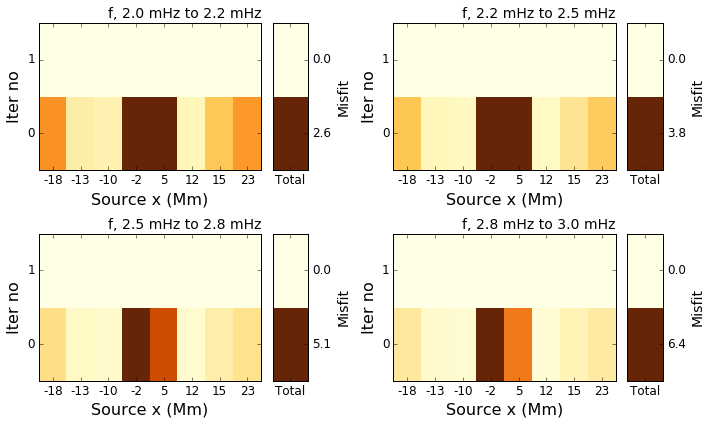

In [13]:
datadir=read_params.get_directory()

nx=read_params.get_nx()
Lx=read_params.get_xlength()
x=np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
nz = read_params.get_nz()

srclocs = np.loadtxt(os.path.join(datadir,"master.pixels"),ndmin=1)
nsrc = len(srclocs)

modes={'0':'f'}
for i in xrange(1,8): modes[str(i)]='p'+str(i)
mode_used = modes[read_params.get_modes_used()[0]]
mode_freq_ranges = {"f":(2,3),
"p1":(2.7,4.2),"p2":(3.1,5.2),"p3":(3.4,5.8),"p4":(3,6),"p5":(3.5,6),"p6":(3.5,6),"p7":(3.5,6)}
full_freq_range = mode_freq_ranges[mode_used]

iters_done = len(os.listdir(os.path.join(datadir,"tt")))
num_freq_ranges = 4

num_iters_plot = min(iters_done,3)
tt_misfits = np.zeros((3,nsrc))

gs_master = gridspec.GridSpec(2,2)

iters_to_plot = np.linspace(0,iters_done,num_iters_plot,endpoint=False).astype(int)

f=plt.figure()
for freq_ind in xrange(num_freq_ranges):
    freq_low = full_freq_range[0]+(full_freq_range[1]-full_freq_range[0])/num_freq_ranges*freq_ind
    freq_high = full_freq_range[0]+(full_freq_range[1]-full_freq_range[0])/num_freq_ranges*(freq_ind+1)
    for src in xrange(nsrc):        
        for iter_index,iter_no in enumerate(iters_to_plot):
            td=np.loadtxt(os.path.join(datadir,"tt","iter"+str(iter_no).zfill(2),
                                       "ttdiff_src"+str(src+1).zfill(2)+"."+
                                    mode_used+"mode."+str(freq_ind)))
            tt_misfits[iter_index,src] = sum((td[:,1]/60)**2/2)
    
    sub_gs = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gs_master[freq_ind])
    ax1 = plt.Subplot(f, sub_gs[0, :-1])
    f.add_subplot(ax1)
    ax1.pcolormesh(tt_misfits,cmap="YlOrBr")
    ax1.set_xticks([0.5+i for i in xrange(nsrc)])
    ax1.set_xticklabels(["{:.0f}".format(srclocs[i]) for i in xrange(nsrc)],fontdict={"size":12})
    ax1.set_yticks([0.5+i for i in xrange(num_iters_plot)])
    ax1.set_yticklabels([str(i) for i in iters_to_plot],fontdict={"size":12})
    ax1.set_title("{}, {:.1f} mHz to {:.1f} mHz".format(mode_used,freq_low,freq_high),fontsize=14,loc='right')
    ax1.set_xlabel("Source x (Mm)",fontsize=16)
    ax1.set_ylabel("Iter no",fontsize=16)
    ax1.set_ylim(0,num_iters_plot)
    
    ax2 = plt.Subplot(f, sub_gs[0,-1])
    f.add_subplot(ax2)
    tt_diff_total = np.sum(tt_misfits,axis=1)[:,None]
    ax2.pcolormesh(tt_diff_total,cmap="YlOrBr")
    ax2.set_yticks([0.5+i for i in xrange(num_iters_plot)])
    ax2.set_yticklabels(np.round(tt_diff_total.flatten(),1),fontdict={"size":12})
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_xticks([0.5])
    ax2.set_xticklabels(["Total"],fontdict={"size":12})
    ax2.set_ylabel("Misfit",fontsize=14)
    ax2.set_ylim(0,num_iters_plot)

plt.gcf().set_size_inches(10,6)
plt.tight_layout()
if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/sourcewise_data_misfit_freqfilt.png")

## Single source: total data misfit

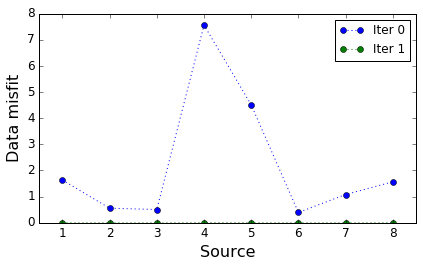

In [15]:
datadir=read_params.get_directory()

nx=read_params.get_nx()
Lx=read_params.get_xlength()
x=np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
nz = read_params.get_nz()

srclocs = np.loadtxt(os.path.join(datadir,"master.pixels"),ndmin=1)
nsrc = len(srclocs)

modes={'0':'f'}
for i in xrange(1,8): modes[str(i)]='p'+str(i)
mode_used = modes[read_params.get_modes_used()[0]]
mode_freq_ranges = {"f":(2,3),
"p1":(2.7,4.2),"p2":(3.1,5.2),"p3":(3.4,5.8),"p4":(3,6),"p5":(3.5,6),"p6":(3.5,6),"p7":(3.5,6)}
full_freq_range = mode_freq_ranges[mode_used]

iters_done = len(os.listdir(os.path.join(datadir,"tt")))
num_freq_ranges = 4

num_iters_plot = min(iters_done,3)
tt_misfits = np.zeros((3,nsrc))

gs_master = gridspec.GridSpec(2,2)

iters_to_plot = np.linspace(0,iters_done,num_iters_plot,endpoint=False).astype(int)

f=plt.figure()
for iter_ind,iter_no in enumerate(iters_to_plot):
    misfit = np.loadtxt(os.path.join(datadir,"update","misfit_"+str(iter_no).zfill(2)))
    plt.plot(misfit[:,0],misfit[:,2],label="Iter "+str(iter_no),marker="o",ls="dotted")

plt.ylabel("Data misfit",fontsize=16)
plt.xlabel("Source",fontsize=16)
plt.xlim(0.5,nsrc+0.5)
plt.xticks(range(1,8+1))
plt.gca().set_xticklabels(range(1,8+1))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="best",fontsize=12)
plt.gcf().set_size_inches(6,3.8)
plt.tight_layout()
if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/sourcewise_data_misfit_total.png")